In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
torch.cuda.empty_cache()

import matplotlib.pyplot as plt
import os    
os.environ['KMP_DUPLICATE_LIB_OK']='True'
random_seed = 420
torch.manual_seed(random_seed)

In [2]:
n_epochs = 100
batch_size_train = 64
batch_size_test = 500

train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST(root='./data', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST(root='./data', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_test, shuffle=True)

In [3]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)
print(example_data.shape)

torch.Size([500, 1, 28, 28])


In [69]:
def uniform_initializer(out_dim, in_dim, cuda = True):
    tensor = torch.empty(out_dim, in_dim)
    if cuda:
        return torch.nn.init.uniform_(tensor, a=-2, b=2).cuda()
    else: 
        return torch.nn.init.uniform_(tensor, a=-2, b=2)
    
class simple_encoder():
    def __init__(self, out_dim, in_dim, cuda = True):
        self.W = uniform_initializer(out_dim, in_dim, cuda)
        
    def apply(self, X):
        #print(X.shape)
        #print(self.W.shape)
        return torch.matmul(self.W, X)
    
class simple_encoder_wthreshold():
    def __init__(self, out_dim, in_dim, epsilon, cuda = True):
        self.W = uniform_initializer(out_dim, in_dim, cuda)
        self.epsilon = epsilon
        
    def apply(self, X):
        #print(X.shape)
        #print(self.W.shape)
        return (torch.matmul(self.W, X) > self.epsilon).float()
    
    def apply_wo_threshold(self, X):
        return torch.matmul(self.W, X)
    
def visualize(s,st):
    fig = plt.figure()
    for i in range(6):
        plt.subplot(2,3,i+1)
        plt.tight_layout()
        plt.imshow(s[i][0], cmap='gray', interpolation='none')
        plt.title("Ground Truth: {}".format(st[i]))
        plt.xticks([])
        plt.yticks([])

torch.Size([6, 1, 28, 28])


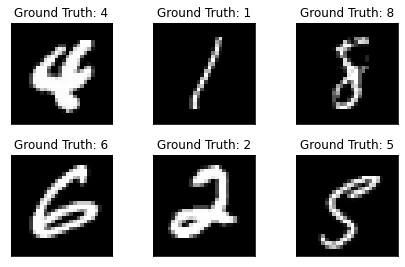

In [70]:
samples = example_data[:6][:][:][:]
sample_target = example_targets[:6]
print(samples.shape)
visualize(samples, sample_target)

torch.Size([19600, 6])
torch.Size([6, 1, 140, 140])


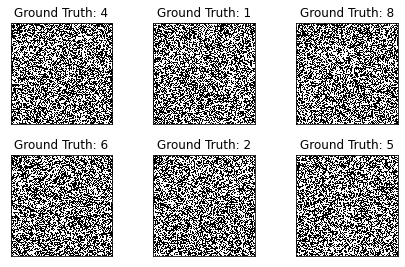

In [71]:
encoder = simple_encoder_wthreshold(784*25, 784, 10e-3,False)
encoded_s = encoder.apply(samples.view(samples.shape[0], samples.shape[1]*samples.shape[2]*samples.shape[3]).T)
print(encoded_s.shape)
encoded_s = encoded_s.T.view(6, 1, int((784*25)**(1/2)), int((784*25)**(1/2)))
print(encoded_s.shape)
visualize(encoded_s, sample_target)

torch.Size([19600, 6])
torch.Size([6, 1, 140, 140])


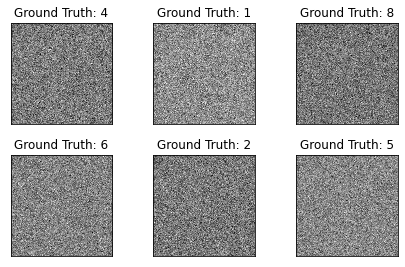

In [72]:
encoded_wo = encoder.apply_wo_threshold(samples.view(samples.shape[0], samples.shape[1]*samples.shape[2]*samples.shape[3]).T)
print(encoded_wo.shape)
encoded_wo = encoded_wo.T.view(6, 1, int((784*25)**(1/2)), int((784*25)**(1/2)))
print(encoded_wo.shape)
visualize(encoded_wo, sample_target)

In [73]:
count_black = np.sum(encoded_s[0].numpy()) #histogram(encoded_s[0], bins=3)
count_white = 140*140 - count_black

9795.0 9805.0


<BarContainer object of 2 artists>

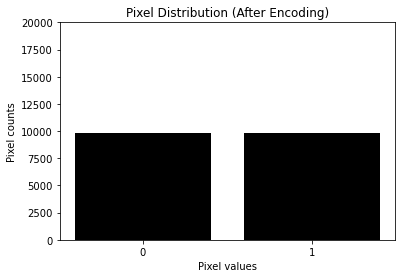

In [74]:
print(count_black, count_white)
plt.ylim([0, 20000])
plt.title("Pixel Distribution (After Encoding)")
plt.xlabel("Pixel values")
plt.ylabel("Pixel counts")
plt.bar(['0', '1'], [count_black, count_white], color = 'black')
#plt.show()

In [75]:
count_raw,label_raw = np.histogram(samples[0], bins=50)

In [76]:
#print(samples[0].flatten().numpy())
#x = [21,22,23,4,5,6,77,8,9,10,31,32,33,34,35,36,37,18,49,50,100]
#num_bins = 5

(array([574.,   9.,   7.,   5.,   5.,  10.,   1.,   2.,   4.,   4.,   4.,
          7.,   4.,   2.,   7.,   2.,   8.,   7.,  10., 112.]),
 array([-0.42421296, -0.261928  , -0.09964299,  0.06264199,  0.22492698,
         0.38721195,  0.54949695,  0.7117819 ,  0.8740669 ,  1.0363519 ,
         1.1986369 ,  1.3609219 ,  1.5232068 ,  1.6854918 ,  1.8477768 ,
         2.0100617 ,  2.1723468 ,  2.3346317 ,  2.4969168 ,  2.6592016 ,
         2.8214867 ], dtype=float32),
 <BarContainer object of 20 artists>)

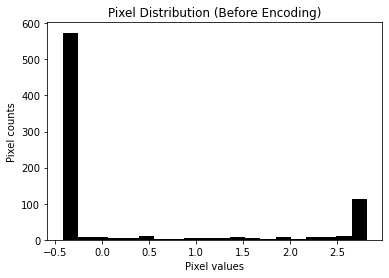

In [77]:
plt.title("Pixel Distribution (Before Encoding)")
plt.xlabel("Pixel values")
plt.ylabel("Pixel counts")
plt.hist(samples[0].flatten().numpy(), 20, color = 'black')

In [78]:
def pixel_correlation_vertical(image):
    #image is WxH numpy array
    x = []
    y = []
    for i in range(W):
        for j in range(H-1):
            x = image[j][i]
            y = image[j+1][i]
    plt.scatter(x, y)
    
def pixel_correlation_adjacent(flattened_image):
    #image is WxH numpy array
    x = []
    y = []
    l = flattened_image.size
    for i in range(l-1):
            x.append(flattened_image[i])
            y.append(flattened_image[i+1])
    plt.scatter(x, y, color = 'black', s = 2)

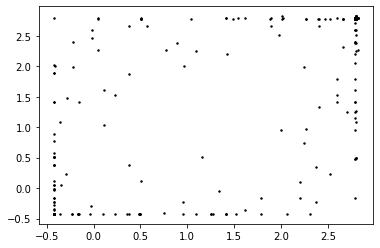

In [79]:
pixel_correlation_adjacent(samples[0].flatten().numpy())

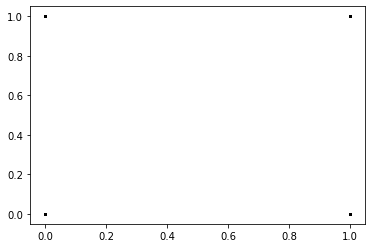

In [80]:
pixel_correlation_adjacent(encoded_s[0].flatten().numpy())

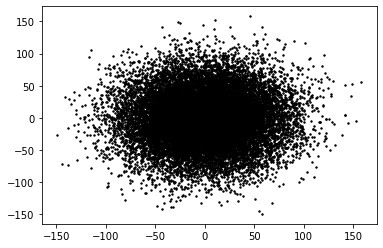

In [81]:
pixel_correlation_adjacent(encoded_wo[0].flatten().numpy())